In [ ]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-06-22 18:53:16,755 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:16,757 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:16,759 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:16,760 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:16,761 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:16,762 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:16,766 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/de

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-06-22 18:53:17,316 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:17,372 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:17,373 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:17,374 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:17,376 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:17,983 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:18,052 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:18,053 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:18,054 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:18,055 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:18,056 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:18,056 - settings - Setting database.pa

In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-06-22 18:53:18,936 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-06-22 18:53:18,938 - settings - Setting database.user to celiib
INFO - 2021-06-22 18:53:18,939 - settings - Setting database.password to newceliipass
INFO - 2021-06-22 18:53:18,941 - settings - Setting enable_python_native_blobs to True
INFO - 2021-06-22 18:53:19,659 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

# Debugging the Cell Type Errors

In [64]:
import numpy as np
import time
import classification_utils as clu
import proofreading_utils as pru
import axon_utils as au
import synapse_utils as syu
import preprocessing_vp2 as pre
import cell_type_utils as ctu

axon_version = au.axon_version
ver = 88

verbose = True
validation = True
inh_exc_class_to_use_for_axon = "Baylor"
key_source = (minnie.Decomposition() & 
                  du.current_validation_segment_id_restriction
                  - du.current_validation_segment_id_exclude)

In [70]:
curr_table = (minnie.schema.jobs & "table_name='__decomposition_cell_type'")
curr_table

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__decomposition_cell_type,3a9977fe0309921114d7ad948205d19d,error,=BLOB=,IndexError: arrays used as indices must be of integer (or boolean) type,=BLOB=,celiib@10.28.0.133,at-node6,1,549056,2021-06-23 13:01:00
__decomposition_cell_type,48a5aef7c4abd7fced95d3dbeed140ed,error,=BLOB=,IndexError: arrays used as indices must be of integer (or boolean) type,=BLOB=,celiib@10.28.0.129,at-node2,1,548994,2021-06-23 13:07:30
__decomposition_cell_type,88cc23cf175d74be27a56afd0262035c,error,=BLOB=,"Exception: Segment ID 864691136672696199 should have been in DecompositionSplit but wasnt with n_error_limbs = 4, n_somas = 2",=BLOB=,celiib@10.28.0.175,at-node48,1,548991,2021-06-23 13:05:46
__decomposition_cell_type,c4c2c7d5612554a90a9ece804e84d1e1,reserved,=BLOB=,,=BLOB=,celiib@10.28.0.83,at-compute004,19172,549415,2021-06-23 15:31:26


In [75]:
print((curr_table & "key_hash='48a5aef7c4abd7fced95d3dbeed140ed'").fetch1("error_stack"))

Traceback (most recent call last):
  File "/meshAfterParty/neuron.py", line 1369, in set_attribute_dict
    [curr_branch.mesh.submesh([k],append=True,repair=False) for k in attribute_dict[branch_idx]])
  File "/meshAfterParty/neuron.py", line 1369, in <listcomp>
    [curr_branch.mesh.submesh([k],append=True,repair=False) for k in attribute_dict[branch_idx]])
  File "/usr/local/lib/python3.6/dist-packages/trimesh/base.py", line 2470, in submesh
    **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/trimesh/util.py", line 1511, in submesh
    current = original_faces[index]
IndexError: index 8725 is out of bounds for axis 0 with size 3982

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/datajoint/autopopulate.py", line 159, in populate
    make(dict(key))
  File "Run_7_DecompositionCellType_val_v6.py", line 292, in make
    ignore_DecompositionCellType = True)
  File "/meshAfterPa

In [73]:
key = (key_source & dict(segment_id=864691135570667757)).proj().fetch1()
key

{'segment_id': 864691135570667757,
 'decimation_version': 0,
 'decimation_ratio': Decimal('0.25'),
 'ver': Decimal('30.00'),
 'process_version': 0,
 'index': 0}

In [76]:
minnie.DecompositionSplit() & key

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,split_version the version of the splitting algorithm used,multiplicity the number of somas found for this base segment,n_splits the number of cuts required to help split the neuron,split_success the successfulness of the splitting,n_error_limbs_cancelled number of limbs that couldn't be resolved and cancelled out,n_same_soma_limbs_cancelled number of same soma touching limbs that couldn't be resolved and cancelled out,n_multi_soma_limbs_cancelled number of multi soma touching limbs that couldn't be resolved and cancelled out,error_imbs_cancelled_area the total area (in microns^2) of the limbs that was cancelled out because touching the same soma multiple times or multiple somas,error_imbs_cancelled_skeletal_length the total skeletal length (in microns) of the limbs that were called out because could not be resolved,split_results will store the results of how to split the limbs of neuron objects from original neuron,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,max_soma_n_faces The largest number of faces of the somas,max_soma_volume The largest volume of the somas the (volume in billions (10*9 nm^3)),n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691135570667757,0,0.25,30.00,0,0,0,2,1,1,0,0,0,0,0.0,0.0,=BLOB=,=BLOB=,792467,1580511,0,0,0,0,1,42527,981,6,183,68,7826214.903255286,2960201.7515257867,31385.605,342.033,288.704,522.756,513.465,3314,0.0004234486327000238,18.10928961748634,5917244.426,128,0.0005600579866936867,25.891,500169244180.31067,69123611.72752634,63909.46969425374,84527.39284904278,3907572220.158677,692.9584


In [78]:
# 1) Pull Down All of the Neurons
segment_id = key["segment_id"]

if verbose:
    print(f"------- Working on Neuron {segment_id} -----")

whole_pass_time = time.time()

#1) Pull Down all the Neuron Objects associated with a segment_id
neuron_objs,neuron_split_idxs = du.decomposition_with_spine_recalculation(segment_id,
                                                                    ignore_DecompositionAxon=True,
                                                                    ignore_DecompositionCellType = True)

if verbose:
    print(f"Number of Neurons found ={len(neuron_objs)}")

#For each neuron:
dict_to_write = []


# -------- getting the nuclei info to match
#         ver = 88
#         nucleus_ids,nucleus_centers = du.segment_to_nuclei(segment_id,
#                                                                nuclei_version=ver)
segment_map_dict = (minnie.AutoProofreadValidationSegmentMap4() & dict(old_segment_id=segment_id)).fetch1()
nucleus_id = segment_map_dict["nucleus_id"]
nuc_center_coords = du.nuclei_id_to_nucleus_centers(nucleus_id)

nucleus_ids = [nucleus_id]
nucleus_centers = [nuc_center_coords]

print(f"nucleus_ids = {nucleus_ids}")
print(f"nucleus_centers = {nucleus_centers}")

for split_index,neuron_obj in zip(neuron_split_idxs,neuron_objs):

    if verbose:
        print(f"--> Working on Split Index {split_index} -----")

    st = time.time()


    # ------------- Does all of the processing -------------------

    #1) ------ Getting the paired nuclei ------
    winning_nucleus_id, nucleus_info = nru.pair_neuron_obj_to_nuclei(neuron_obj,
                             "S0",
                              nucleus_ids,
                              nucleus_centers,
                             nuclei_distance_threshold = 15000,
                              return_matching_info = True,
                             verbose=True)

    # else:
    #     winning_nucleus_id = 12345
    #     nucleus_info = dict()
    #     nucleus_info["nucleus_id"] = winning_nucleus_id
    #     nucleus_info["nuclei_distance"] = 0
    #     nucleus_info["n_nuclei_in_radius"] = 1
    #     nucleus_info["n_nuclei_in_bbox"] = 1

    if verbose:
        print(f"nucleus_info = {nucleus_info}")
        print(f"winning_nucleus_id = {winning_nucleus_id}")


    #2) ------- Finding the Allen Cell Types -------
    allen_cell_type_info = ctu.allen_nuclei_classification_info_from_nucleus_id(winning_nucleus_id)
    if verbose:
        print(f"allen_cell_type_info = {allen_cell_type_info}")


    #4) -------- Running the cell classification and stats--------------

    if verbose:
        print(f"\n\n ------ Part C: Inhibitory Excitatory Classification ---- \n\n")

    filter_time = time.time()

    (inh_exc_class,
     spine_category,
     axon_angles,
     n_axons,
     n_apicals,
     neuron_spine_density,
     n_branches_processed,
     skeletal_length_processed,
     n_branches_in_search_radius,
     skeletal_length_in_search_radius
     ) = clu.inhibitory_excitatory_classifier(neuron_obj,
                                        return_spine_classification=True,
                                        return_axon_angles=True,
                                         return_n_axons=True,
                                         return_n_apicals=True,
                                         return_spine_statistics=True,
                                             axon_limb_branch_dict_precomputed=None,
                                        axon_angles_precomputed=None,
                                             verbose=verbose)
    if verbose:
        print(f"Total time for classification = {time.time() - filter_time}")

    all_axon_angles = []
    for limb_idx,limb_data in axon_angles.items():
        for candidate_idx,cand_angle in limb_data.items():
            all_axon_angles.append(cand_angle)

    if len(axon_angles)>0:
        axon_angle_maximum = np.max(all_axon_angles)
    else:
        axon_angle_maximum = 0


    if verbose:
        print("\n -- Cell Type Classification Results --")
        print(f"inh_exc_class={inh_exc_class}")
        print(f"spine_category={spine_category}")
        print(f"axon_angles={axon_angles}")
        print(f"n_axons={n_axons}")
        print(f"n_apicals={n_apicals}")
        print(f"neuron_spine_density={neuron_spine_density}")
        print(f"n_branches_processed={n_branches_processed}")
        print(f"skeletal_length_processed={skeletal_length_processed}")
        print(f"n_branches_in_search_radius={n_branches_in_search_radius}")
        print(f"skeletal_length_in_search_radius={skeletal_length_in_search_radius}")

    baylor_cell_type_info = dict(
                cell_type_predicted=inh_exc_class,
                 spine_category=spine_category,
                axon_angle_maximum = axon_angle_maximum,
                 n_axons=n_axons,
                 n_apicals=n_apicals,
                 spine_density_classifier=neuron_spine_density,
                 n_branches_processed=neuron_spine_density,
                 skeletal_length_processed=skeletal_length_processed,
                 n_branches_in_search_radius=n_branches_in_search_radius,
                 skeletal_length_in_search_radius=skeletal_length_in_search_radius,

    )



    #5) ----- Deciding on cell type to use for axon 
    e_i_class = inh_exc_class
    if inh_exc_class_to_use_for_axon == "Allen" and allen_cell_type_info["e_i"] is not None:
        e_i_class = allen_cell_type_info["e_i"]

    if verbose:
        print(f"e_i_class = {e_i_class} with inh_exc_class_to_use_for_axon = {inh_exc_class_to_use_for_axon}")



    #6) -------- If excitatory running the axon processing--------------
    """
    Psuedocode: 
    If e_i class is excitatory:
    1) Filter away the axon on dendrite
    2) Do the higher fidelity axon processing
    3) Compute the axon features

    """

    if e_i_class == "excitatory" and neuron_obj.axon_limb_name is not None:
        if verbose:
            print(f"Excitatory so performing high fidelity axon and computing axon features")
    #     1) Filter away the axon on dendrite
    #     2) Do the higher fidelity axon processing

        o_neuron, filtering_info = au.complete_axon_processing(neuron_obj,
                                                              perform_axon_classification = False,
                                                              return_filtering_info = True)
        filtering_info = {k:np.round(v,2) for k,v in filtering_info.items() if "area" in k or "length" in k}
        #3) Compute the axon features
        axon_features = au.axon_features_from_neuron_obj(o_neuron)
    else:
        nru.clear_all_branch_labels(neuron_obj,labels_to_clear="axon")
        o_neuron = neuron_obj
        axon_features = dict()
        filtering_info = dict()



    #3) ------ Adding the Synapses -----------
    o_neuron = syu.add_synapses_to_neuron_obj(o_neuron,
                    validation = validation,
                    verbose  = True,
                    original_mesh = None,
                    plot_valid_error_synapses = False,
                    calculate_synapse_soma_distance = False,
                    add_valid_synapses = True,
                      add_error_synapses=False)



#     # ------- Saving off the neuron object ----------------
#     save_time = time.time()
#     ret_file_path = o_neuron.save_compressed_neuron(
#                                     output_folder=str(du.get_decomposition_path()),
#                                     #output_folder = "./",
#     file_name=f"{o_neuron.segment_id}_{split_index}_split_axon_v{au.axon_version}",
#                                       return_file_path=True,
#                                      export_mesh=False,
#                                      suppress_output=True)

#     ret_file_path_str = str(ret_file_path.absolute()) + ".pbz2"

#     if verbose:
#         print(f"ret_file_path_str = {ret_file_path_str}")
#         print(f"Save time = {time.time() - save_time}")

#     n_dict = dict(key,
#       split_index = split_index,
#       axon_version = au.axon_version,
#      decomposition=ret_file_path_str,
#       run_time = np.round(time.time() - st,2),
#     cell_type_for_axon = e_i_class,
#      )

#     dicts_for_update = [baylor_cell_type_info,
#                         allen_cell_type_info,
#                         nucleus_info,
#                         filtering_info,
#                         axon_features]

#     for d in dicts_for_update:
#         n_dict.update(d)

------- Working on Neuron 864691135570667757 -----
**Using table __decomposition_split for table_to_neuron_objs**
Decompressing Neuron in minimal output mode...please wait


IndexError: arrays used as indices must be of integer (or boolean) type

In [67]:
from pathlib import Path

In [68]:
P = Path("/mnt/dj-stor01/platinum/minnie65/02/decomposition/864691135501833053_0_split_axon_v6.pbz2")
P.exists()

True

In [83]:
minnie.SpineRecalculation() & "n_spines_new > 100"

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,spine_version the version of the spine algorithm,"updated_spines whether or not the spines were updated (1 = yes, 0 = no)",n_spines_old number of spines before recalculation,n_spines_new number of spines after recalculation,spine_data stores the newly computes spines that were used for the classification,run_time the amount of time to run (seconds)
864691134878379514,0,0.25,30.00,0,0,0,0,1,190,163,=BLOB=,129.9105
864691134884741114,0,0.25,30.00,0,0,0,0,1,2333,2179,=BLOB=,1866.7771
864691134884741370,0,0.25,30.00,0,0,0,0,1,888,840,=BLOB=,310.6599
864691134884741626,0,0.25,30.00,0,0,0,0,1,2757,2575,=BLOB=,948.652
864691134884742138,0,0.25,30.00,0,0,0,0,1,1112,1047,=BLOB=,413.6564
864691134884742394,0,0.25,30.00,0,0,0,0,1,167,179,=BLOB=,98.4681
864691134884742650,0,0.25,30.00,0,0,0,0,1,1217,1175,=BLOB=,1105.5559
864691134884742906,0,0.25,30.00,0,0,0,0,1,1182,939,=BLOB=,431.7799
864691134884743162,0,0.25,30.00,0,0,0,0,1,1072,982,=BLOB=,357.3399
864691134884743418,0,0.25,30.00,0,0,0,0,1,1186,1105,=BLOB=,3178.1212


In [86]:
minnie.DecompositionSplit() & ((minnie.Decomposition() & "process_version < 3") & (minnie.SpineRecalculation() & "n_spines_new > 100").proj()).proj()

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,split_version the version of the splitting algorithm used,multiplicity the number of somas found for this base segment,n_splits the number of cuts required to help split the neuron,split_success the successfulness of the splitting,n_error_limbs_cancelled number of limbs that couldn't be resolved and cancelled out,n_same_soma_limbs_cancelled number of same soma touching limbs that couldn't be resolved and cancelled out,n_multi_soma_limbs_cancelled number of multi soma touching limbs that couldn't be resolved and cancelled out,error_imbs_cancelled_area the total area (in microns^2) of the limbs that was cancelled out because touching the same soma multiple times or multiple somas,error_imbs_cancelled_skeletal_length the total skeletal length (in microns) of the limbs that were called out because could not be resolved,split_results will store the results of how to split the limbs of neuron objects from original neuron,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,max_soma_n_faces The largest number of faces of the somas,max_soma_volume The largest volume of the somas the (volume in billions (10*9 nm^3)),n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134878379514,0,0.25,30.00,0,0,0,2,1,1,0,0,0,0,0.0,0.0,=BLOB=,=BLOB=,184936,369935,0,0,0,0,1,19785,167,5,89,47,1302333.9862573813,650792.2048713105,11594.159,148.579,148.579,431.667,416.629,164,0.00012592775872439572,1.8426966292134832,674077.635,48,0.0002432954180418699,3.417,34196989566.216156,54207494.116666794,26258.23323899479,50731.52970906111,712437282.6295033,82.9592
864691134884742394,0,0.25,30.00,0,0,0,2,1,1,0,0,0,0,0.0,0.0,=BLOB=,=BLOB=,180848,360013,0,0,0,0,1,25557,470,8,71,43,3555740.0658564987,1553147.4052075923,35053.668,93.767,93.767,277.293,274.39,132,3.712307355296067e-05,1.8591549295774648,1452675.168,23,9.086683858011676e-05,5.739,40705481816.736855,146565582.96327972,11447.822693116857,28021.048830055344,1769803557.2494285,224.4661
864691134884742

# Getting the Results of the Validation

In [90]:
minnie.AutoProofreadValidationScore6()

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,189149,864691135855890478,0.08,0,=BLOB=,369.84999619148164,=BLOB=,=BLOB=,7,160,11,0,0.3888888888888889,1.0,0.56,5280,7,39,4,0.9926677946982515,0.9992429977289932,0.995944543996982,513.17
88.00,223037,864691136227167569,0.08,0,=BLOB=,63.375728490237755,=BLOB=,=BLOB=,0,450,0,0,nan,nan,nan,1,3416,3853,0,0.0002594706798131811,1.0,0.0005188067444876783,379.98
88.00,225498,864691135753932237,0.08,0,=BLOB=,185.8554437449504,=BLOB=,=BLOB=,6,77,0,5,1.0,0.5454545454545454,0.7058823529411764,1124,0,0,9,1.0,0.9920564872021183,0.9960124058484714,164.73
88.00,230236,864691135609687047,0.08,0,=BLOB=,1400.0527722290963,=BLOB=,=BLOB=,31,552,9,19,0.775,0.62,0.6888888888888889,1960,22,1,2,0.9994900560938297,0.9989806320081549,0.99923527912312,669.91
88.00,236197,864691136903144370,0.08,0,=BLOB=,40.753447012345966,=BLOB=,=BLOB=,0,974,0,6,nan,0.0,nan,2750,2333,3,48,0.9989102796948783,0.9828448892065761,0.9908124662223023,565.32
88.00,258307,864691135293126156,0.08,0,=BLOB=,1095.334412475715,=BLOB=,=BLOB=,43,335,17,27,0.7166666666666667,0.6142857142857143,0.6615384615384615,2984,7,25,19,0.9916915918909937,0.9936729936729937,0.9926813040585496,477.05
88.00,262773,864691136023889209,0.08,0,=BLOB=,183.47810007157142,=BLOB=,=BLOB=,10,47,2,0,0.8333333333333334,1.0,0.9090909090909091,724,0,2,10,0.9972451790633609,0.9863760217983651,0.9917808219178083,108.24
88.00,264870,864691136951664863,0.08,0,=BLOB=,1059.704640497908,=BLOB=,=BLOB=,31,421,3,1,0.9117647058823529,0.96875,0.9393939393939394,2008,25,4,33,0.9980119284294234,0.9838314551690348,0.9908709597828769,333.17
88.00,269247,864691135584074360,0.08,0,=BLOB=,1993.0556380165044,=BLOB=,=BLOB=,187,10,4,83,0.9790575916230366,0.6925925925925925,0.8112798264642083,805,0,7,66,0.9913793103448276,0.9242250287026407,0.9566250742721331,280.0
88.00,269380,864691135974639471,0.08,0,=BLOB=,451.5681577333852,=BLOB=,=BLOB=,27,255,6,11,0.8181818181818182,0.7105263157894737,0.7605633802816901,1863,4,8,3,0.9957242116515232,0.9983922829581994,0.9970564624029972,258.88


In [91]:
training_set = minnie.AutoProofreadValidationSegment.proj(old_segment_id="segment_id").fetch("old_segment_id")
training_set      

array([864691134988386682, 864691135113167769, 864691135212632448,
       864691135212690816, 864691135233108569, 864691135272164113,
       864691135348272855, 864691135382947307, 864691135393964789,
       864691135407289801, 864691135491233631, 864691135501578306,
       864691135510455760, 864691135564655959, 864691135589906955,
       864691135589907979, 864691135645592260, 864691135699269154,
       864691135735426708, 864691135736387732, 864691135737374100,
       864691135740225387, 864691135748568361, 864691135748575017,
       864691135771629819, 864691135785277636, 864691135865518469,
       864691135866394390, 864691135925564174, 864691135945413668,
       864691135974454383, 864691135974454639, 864691135974454895,
       864691136003930314, 864691136008425132, 864691136008573614,
       864691136056340440, 864691136056391384, 864691136099807093,
       864691136105484249, 864691136105491417, 864691136105493209,
       864691136105498585, 864691136134446219, 864691136175008

In [92]:
validation_table_pd = vu.current_validation_df()

# On Training Set

Segment Id = 864691134988386682
Postsyn counts:
TP:214488
TN:1152
FP:327
FN:1611
Presyn counts:
TP:1678
TN:10362
FP:344
FN:673


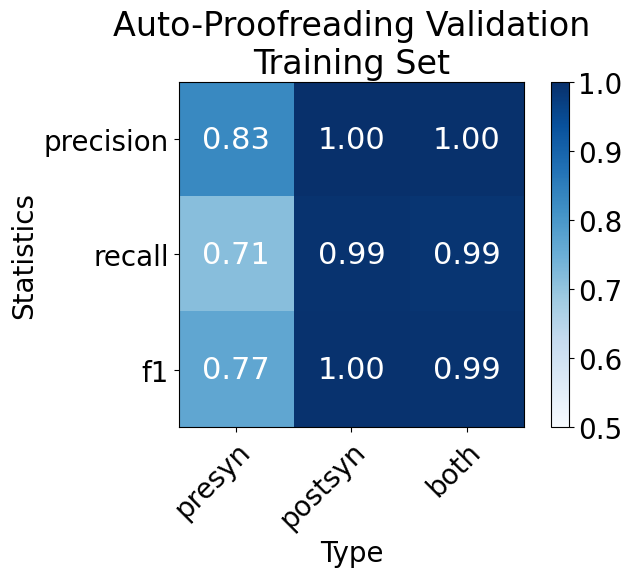

In [93]:
training_df = validation_table_pd[validation_table_pd["old_segment_id"].isin(training_set)]
vu.validation_df_to_score_plot(training_df,
                              title_append = "Training Set")

# With the held out neurons

In [94]:
held_out_df = validation_table_pd[~validation_table_pd["old_segment_id"].isin(training_set)]

Segment Id = 864691134988385914
Postsyn counts:
TP:278361
TN:115135
FP:9766
FN:8217
Presyn counts:
TP:699
TN:15596
FP:249
FN:294


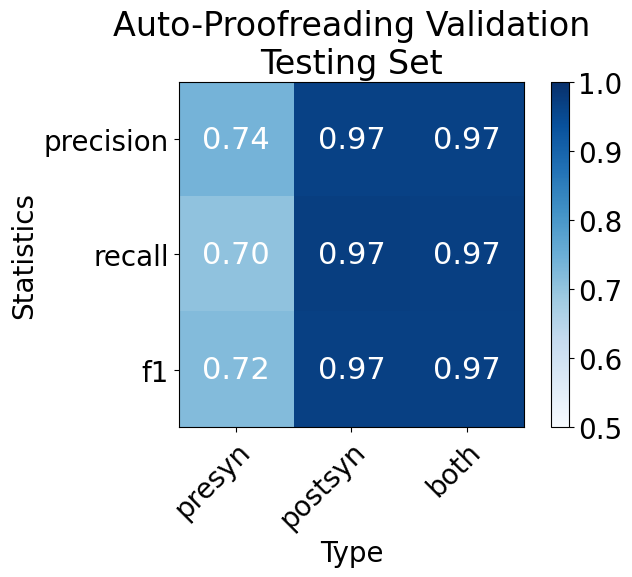

In [95]:
vu.validation_df_to_score_plot(held_out_df,title_append = "Testing Set")

In [96]:
n_somas,n_glia = held_out_df["n_somas"].to_numpy(),held_out_df["n_glia"].to_numpy()

In [97]:
n_somas

array([1, 2, 2, 1, 2, 1, 1, 1, 1, 5, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 4, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2,
       1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1])

In [98]:
n_glia

array([0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
len(np.where(n_somas>1)[0])/len(n_somas)

0.36065573770491804

In [100]:
np.sum(n_glia)

4

# Overall Accuracy

Segment Id = 864691134988385914
Postsyn counts:
TP:492849
TN:116287
FP:10093
FN:9828
Presyn counts:
TP:2377
TN:25958
FP:593
FN:967


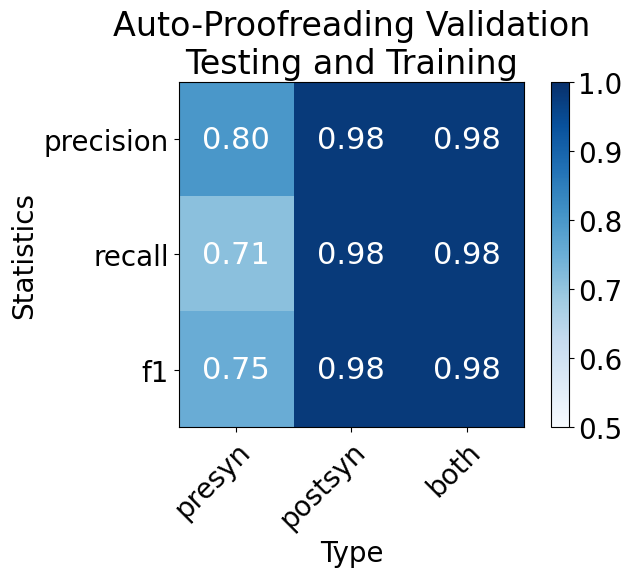

In [101]:
vu.validation_df_to_score_plot(validation_table_pd,
                              title_append = "Testing and Training")

# on the training set

In [ ]:
curr_table2 = ((minnie.AutoProofreadValidationScore5() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table2

In [ ]:
(curr_table2 & dict(segment_id=864691136378815445)).fetch1("decomposition")

In [ ]:
curr_table = ((minnie.AutoProofreadValidationScore4() * minnie.AutoProofreadValidationSegmentMap4())
 & (dj.U("old_segment_id") & minnie.AutoProofreadValidationBorderNeurons().proj(old_segment_id="segment_id")))
curr_table

In [ ]:
seg_ids,pre_recall_v4 = curr_table.fetch("segment_id","pre_recall")
pre_recall_v5 = curr_table2.fetch("pre_recall")

In [ ]:
recall_diff = (pre_recall_v4 - pre_recall_v5)
indices_recall_diff = np.where(recall_diff > 0)[0]
print(recall_diff[indices_recall_diff])
print(seg_ids[indices_recall_diff])

In [ ]:
curr_table2 & dict(segment_id=864691135415666362)

In [ ]:
total_validation_df = vu.table_to_score_plot(curr_table,
                       return_validation_df=True)